In [553]:
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from scipy.spatial import KDTree, distance
import scipy as sp
import networkx as nx
from point_cloud import Tree
from utils import Segm
from branch import kill_attr, Sum2di

In [610]:
# plt.style.available
plt.style.use('seaborn-v0_8-ticks')

# Setup

In [611]:
new_version = True

In [612]:
class Leaf:
    def __init__(self, leaf):
        self.xy = leaf
        self.reached = False
    #     self.my_branch_coords = None
    #     self.my_branch_dist = None

    # def nearby_branch(self, branch):
    #     dist = distance.euclidean(self.xy, branch.segm)

    #     if self.my_branch_dist == None:
    #         self.my_branch_coords = branch.segm
    #         self.my_branch_dist = dist
    #         return True

    #     elif dist < self.my_branch_dist:
    #         assertTrue(dist < self.my_branch_dist)
    #         self.my_branch_coords = branch.segm
    #         self.my_branch_dist = dist
    #         return True
    #     else:
    #         return False

    # def nearby_branch_reset(self):
    #     self.my_branch_coords = None
    #     self.my_branch_dist = None


class Branch:
    def __init__(self, pos, di, l):
        self.pos = pos
        self.direction = di
        self.length = l
        self.segm = Segm(pos, di, l)
        self.attracted = False


# def grow():
#     pass

In [613]:
def match(collection, br):
    for i in collection:
        if i.segm[0] == br.segm[0] and i.segm[1] == br.segm[1]:
            return True
        else:
            return False
            
def draw_circle(x, y, r):
    stepSize = 0.1
    positions = []
    t = 0
    while t < 2 * np.pi:
        positions.append((r * np.cos(t) + x, r * np.sin(t) + y))
        t += stepSize

    return np.array(positions)

# Parameters

In [731]:
# Radius
R = 1
# Attractoin range
max_dist = 0.5*R
# Kill distance
min_dist = 0.08*R

# Branch length
Bl = 0.04*R

# Number of points
N = 100

cloud = Tree(N, R)
LEAVES = [Leaf(l) for l in cloud.leaves]
tree = KDTree(cloud.leaves)
center = cloud.center

initial_br = Branch(np.array([0, 0]), np.array([0, 1]), Bl)
crusaders = [initial_br, 
Branch(np.array([0, 0]), np.array([0, -1]), Bl),
Branch(np.array([0, 0]), np.array([1, 0]), Bl),
Branch(np.array([0, 0]), np.array([-1, 0]), Bl)]

In [732]:

t1 = tree.query_ball_point([0, 0], r=0.1, return_length=True)
t2 = KDTree([l.xy for l in LEAVES], R).query_ball_point([0, 0], r=0.1, return_length=True)
t1==t2

True

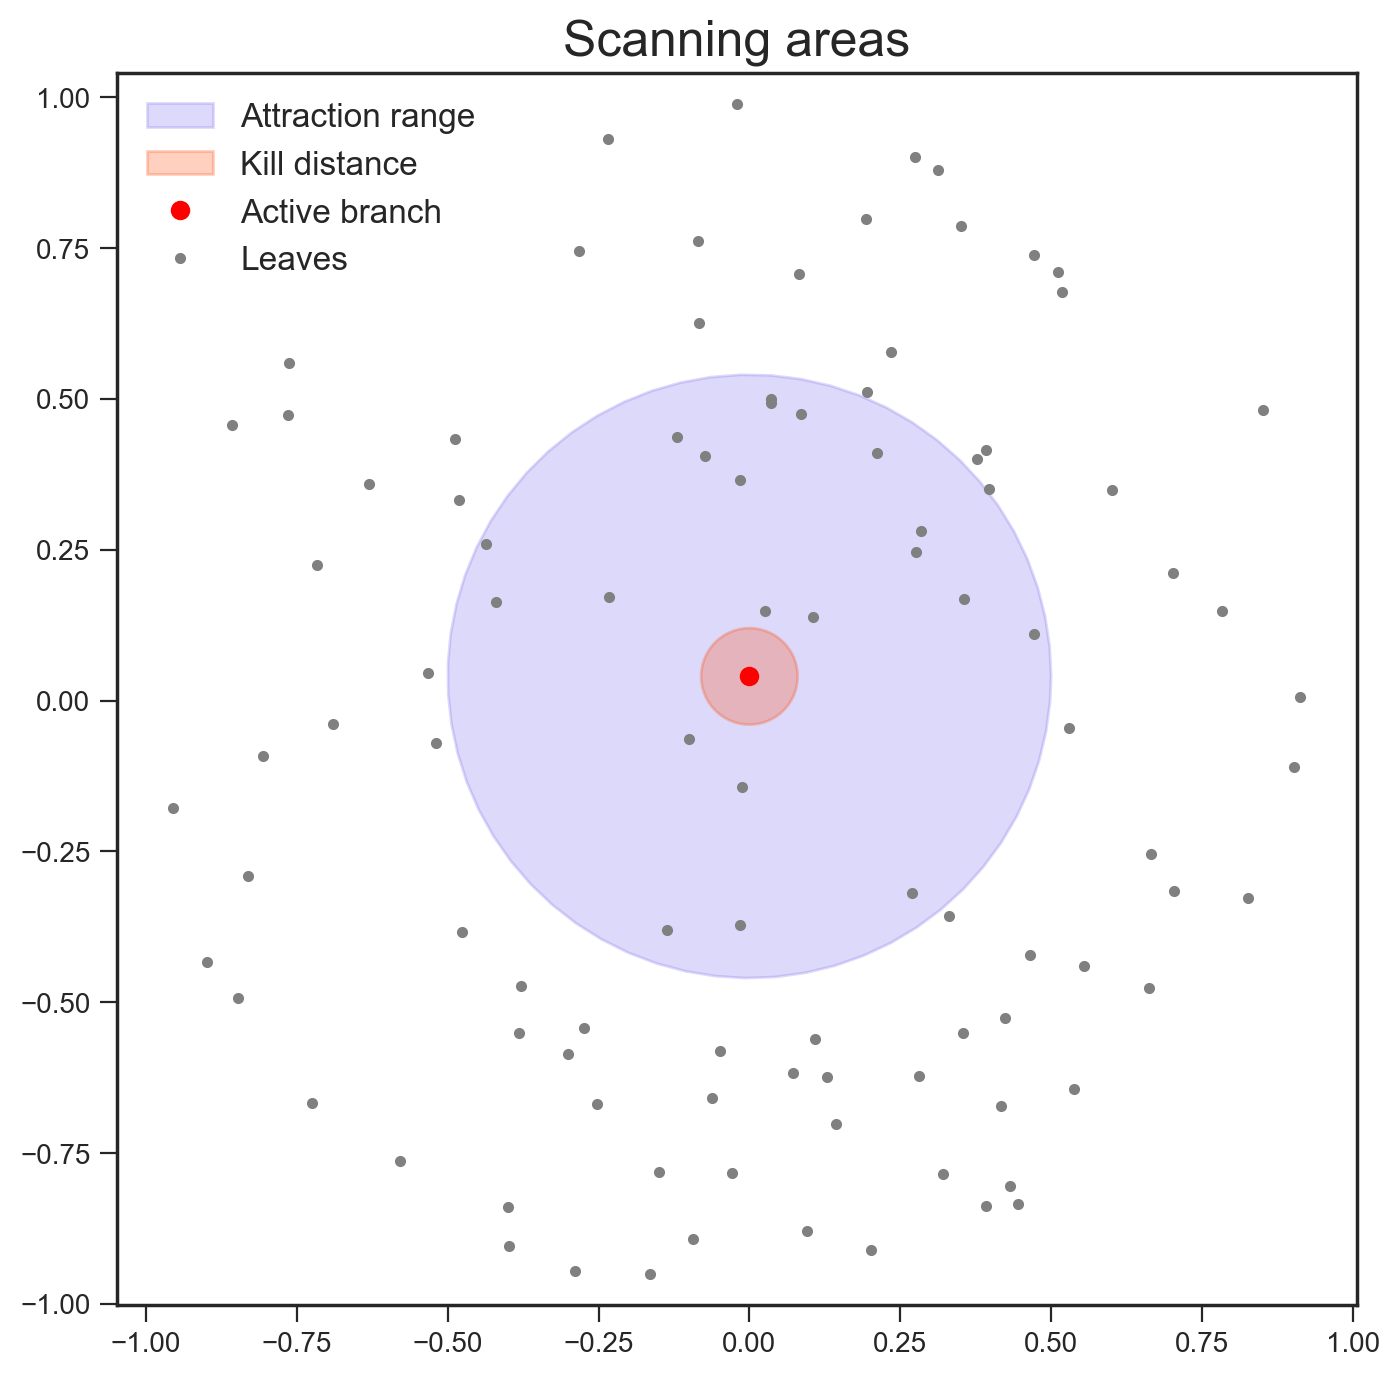

In [733]:
fig = plt.figure(figsize=(8,8), dpi=200)
tree.query_ball_point(initial_br.segm, r=min_dist, return_length=True)
x, y = initial_br.segm
Dk = draw_circle(x, y, min_dist)
Ar = draw_circle(x, y, max_dist)
plt.fill(Ar[:, 0], Ar[:, 1], color='mediumslateblue', alpha=0.25, label='Attraction range')
plt.fill(Dk[:, 0], Dk[:, 1], color='orangered', alpha=0.25, label='Kill distance')
plt.plot(x, y, 'o', color='r', label='Active branch')
plt.plot(cloud.leaves[:, 0], cloud.leaves[:, 1], '.', color='gray', label='Leaves')
plt.axis('equal')
plt.title('Scanning areas', fontsize=18)
plt.legend(fontsize = 'large')

In [734]:
# roots = [initial_br]
roots = crusaders

# branches = [initial_br]
branches = crusaders

#graph tree - coming soon :)
graph = nx.DiGraph()

# Code

In [735]:
def grow_straight(branch):
    '''
    Moves along current branch direction
    '''
    return Branch(branch.segm, branch.direction, branch.length)

def grow_to_source(branch, source_point):
    '''
    Grow towards single source
    '''
    next_br = grow_straight(branch)
    new_di = Sum2di(next_br.segm, source_point)
    new_br = Branch(start_br.segm, new_di, Bl)
    return new_br

def grow_to_sources(branch, leaves):
    '''
    Grow towards multiple sources
    '''
    tree = KDTree(leaves)
    sources = []
    for s in tree.query_ball_point(branch.segm, r=max_dist):
        di = leaves[s]
        sources.append(di)
    new_di = sum(map(lambda x: Sum2di(branch.direction, x), sources))/len(sources)
    new_di = new_di/np.linalg.norm(new_di)
    return Branch(branch.segm, new_di, branch.length)

def branch_of_interest(leaf, branches):
    '''
    Looks for closest branch to selected leaf
    Returns distance and actual closest branch
    '''
    l_cords = leaf.xy
    BR_tree = KDTree([b.segm for b in branches])
    # connection
    dist, i = BR_tree.query(l_cords, k=1)
    branch = branches[i]

    return dist, branch

def sort_sources(leaves, branches):
    '''
    Connect sources (leaves) to targets (branches)
    '''
    connections = {}
    for b in branches:
        connections[b] = []

    # choose closest branch for every leaf and add it to corresponding list
    for l in leaves:
        dist, branch = branch_of_interest(l, branches)
        if dist < max_dist:
            connections[branch].append(l.xy)
    # remove empties
    connections_filtered = {k: v for k, v in connections.items() if len(v)>0}
    return connections_filtered

In [736]:
found = False
current = initial_br
while found == False:
    dist, num = tree.query(current.segm, k=1)
    if dist<max_dist:
        found = True
    if found == False:
        new_br = grow_straight(current)
        current = new_br
        branches.append(current)

In [737]:
branches

In [738]:
if new_version == False:   
    # not_reached_l = list(filter(lambda x: x.reached == False, LEAVES))
    # while len(not_reached_l) > 0:
    for i in range(10):
        # stop = []
        for l in LEAVES:
            l_cords = l.xy

            if l.reached == True:
                #those leaves has left the game
                continue
            if list(filter(lambda x: x.reached == False, LEAVES)) == 0:
                break

            for n, b in enumerate(roots):

                dist = distance.euclidean(l_cords, b.segm)
                if dist < min_dist:
                    #WoW, this is kill distance
                    #Your time has come, leaf
                    l.reached = True
                    not_reached_l = list(filter(lambda x: x.reached == False, LEAVES))
                    not_reached_l = [l.xy for l in not_reached_l]
                    tree = KDTree(not_reached_l)

                if dist > max_dist:
                    # we are out of point cloud, thus branch do not have to grow
                    continue
            
        for b in roots:
            # if match(stop, b) == True:
            #         continue
                
            not_reached_l = list(filter(lambda x: x.reached == False, LEAVES))

            if tree.query_ball_point(b.segm, r=max_dist, return_length=True)>0:
                my_sources = [l.xy for l in not_reached_l]
                new_br = grow_to_sources(b, my_sources)
                
                if match(branches, new_br) == True:
                    continue

                else: 
                    branches.append(new_br)

                    # elif len(not_reached_l) != 0:
                    #     new_br = grow_straight(b)
                    #     branches.append(b)
        roots = copy(branches)


In [739]:
# result = np.array([b.segm for b in branches])
# len(result)

# V2

In [740]:
if new_version == True:
    
    for i in range(50):
        for l in LEAVES:
            l_cords = l.xy

            if list(filter(lambda x: x.reached == False, LEAVES)) == 0:
                # entire collection reached
                break

            for n,b in enumerate(roots):
                dist = distance.euclidean(l_cords, b.segm)
                if dist < min_dist:
                    #WoW, this is kill distance
                    #Your time has come, leaf
                    l.reached = True
                    not_reached_l = list(filter(lambda x: x.reached == False, LEAVES))
                    not_reached_l = [l.xy for l in not_reached_l]
                    tree = KDTree(not_reached_l)

                if dist > max_dist:
                    # we are out of point cloud, thus branch do not have to grow
                    continue

            if l.reached == True:
                #this leaf has left the game
                continue

        #     BR_tree = KDTree([b.segm for b in roots])
        #     # cycle = {}
        #     connections = BR_tree.query_ball_point(l_cords, r=max_dist)
        #     if len(connections)>0:
        #         for idx in connections:
        #             l.nearby_branch(roots[idx])
        #             # n = l.nearby_branch(roots[idx])
        #             # if n != False:
        #             #     cycle[f'{l.xy}'] = roots[idx].segm
        #                 # print(f'leaf {l.xy} distance = {l.my_branch_dist}', end=',\n', flush=True)
        # print(cycle)
        # for b in roots:
        #     # for l in LEAVES:
        #     #     if l.my_branch_coords == b.segm:
        #     not_reached_l = list(filter(lambda x: x.reached == False, LEAVES))

        #     if tree.query_ball_point(b.segm, r=max_dist, return_length=True)>0:
        #         my_sources = list(filter(lambda x: f'{x.my_branch_coords}' == f'{b.segm[0]}', not_reached_l))
        #         my_sources = [l.xy for l in my_sources]
                # print(my_sources)
                # new_br = grow_to_sources(b, my_sources)
                
                # if match(branches, new_br) == True:
                #     continue

                # else: 
                #     branches.append(new_br)
        
        connections = sort_sources(LEAVES, roots)
        assert len(connections)!=0

        print(connections)
        for k in connections.keys():
            sources = connections[k]
            new_br = grow_to_sources(k, sources)
            if match(branches, new_br) == True:
                continue
            else: 
                branches.append(new_br)
        roots = copy(branches)

{<__main__.Branch object at 0x7fee7e377f70>: [array([0.02645478, 0.14811261]), array([0.03599859, 0.49953509]), array([0.21192277, 0.40937934]), array([-0.12076072,  0.43642131]), array([-0.07337484,  0.40574175]), array([-0.01629136,  0.36508659]), array([0.08502112, 0.47539618]), array([0.03596959, 0.49285042]), array([0.10595068, 0.13801444])], <__main__.Branch object at 0x7fee7e376290>: [array([ 0.33108137, -0.35778838]), array([ 0.26885625, -0.31860486]), array([-0.01204124, -0.14307991]), array([-0.13675791, -0.38040712]), array([-0.01522218, -0.37216568])], <__main__.Branch object at 0x7fee7e3765c0>: [array([0.28407904, 0.28067307]), array([ 0.53033074, -0.04519719]), array([0.47236095, 0.10941629]), array([0.27543007, 0.24545524]), array([0.35556989, 0.16888247])], <__main__.Branch object at 0x7fee7e3765f0>: [array([-0.51952111, -0.06959397]), array([-0.43571516,  0.25958257]), array([-0.10022551, -0.06341046]), array([-0.41998383,  0.16292772]), array([-0.23317071,  0.17168748

In [741]:
result = np.array([b.segm for b in branches])
result

array([[ 0.        ,  0.04      ],
       [ 0.        , -0.04      ],
       [ 0.04      ,  0.        ],
       ...,
       [ 0.40920359, -0.86426416],
       [ 0.43011049, -0.89836551],
       [-0.74263217,  0.24907942]])

# Plot result

(-1.1607261064076264,
 1.087438108397101,
 -1.1288223615681408,
 1.1326279329595805)

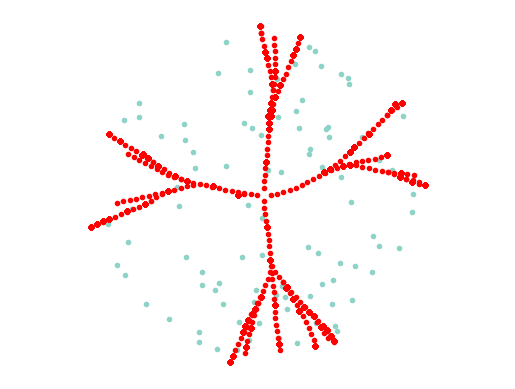

In [742]:
plt.plot(cloud.leaves[:, 0], cloud.leaves[:, 1], '.')
plt.plot(result[:, 0], result[:, 1], '.', color='r')
plt.axis('equal')
plt.axis('off')
# plt.xlim(-.01, 0.05)

# Bottom
*for some random stuff*

In [570]:
d = {}
for i in range(10):
    d[i] = []

for k in d.keys():
    d[k].append(np.random.randint(10))
    if np.random.random() > 0.5:
        d[k].append(np.random.randint(10))

d

{0: [1, 3],
 1: [9],
 2: [5, 5],
 3: [8],
 4: [8],
 5: [8],
 6: [8, 8],
 7: [8, 6],
 8: [0],
 9: [3, 2]}

In [573]:
 {k: v for k, v in d.items() if len(v)>1}

{0: [1, 3], 2: [5, 5], 6: [8, 8], 7: [8, 6], 9: [3, 2]}

In [479]:
test = [1, 1, 0, 1]

for t in test:
    if t == 0:
        continue
    if type(t) == type(int()):
        print('int')

int
int
int
